## A very brief introduction to image processing and particle image velocimetry (PIV)

First, we begin with importing a number of libraries. These include:
* [numpy](https://numpy.org/ "Numerical Python")
* [skimage](https://scikit-image.org/ "Scientific Image Processing")
* [matplotlib](https://matplotlib.org/ "Matplotlib: Visualization with Python")
* [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/ "Interactive Widgets")
* [openpiv](http://www.openpiv.net/ "Particle Image Velocimetry")

<br>
If you get an error message in regards to the `openpiv` or `numdifftools` then you will need to do the following: <br>

open up an [Anaconda Prompt](https://docs.anaconda.com/anaconda/user-guide/getting-started/#cli-hello "Anaconda Prompt"). Then just type: <br>

> `pip install numdifftools`


<br>You'll also need to install the Python package [openpiv](https://github.com/OpenPIV/openpiv-python "openpiv"). To install, you'll again open up an Anaconda Prompt and type: <br>
> `conda install -c conda-forge openpiv`

If you needed to install these modules, then you'll have to restart Jupyter notebook.

In [2]:
from io import BytesIO
import numpy as np
import pandas as pd
from ipywidgets import Layout, interact, fixed, interactive, interact_manual
from IPython.display import Image
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import sys
from scipy import ndimage
from scipy.ndimage import gaussian_filter1d as gf1d
from skimage import measure
%matplotlib notebook
import matplotlib
from matplotlib import pylab
import skimage
from skimage import filters, feature, io
from matplotlib import cm
from matplotlib.pyplot import figure
from skimage.filters import roberts, sobel, sobel_h, sobel_v, scharr, \
    scharr_h, scharr_v, prewitt, prewitt_v, prewitt_h
import numdifftools as nd
import openpiv
from openpiv import tools, scaling, pyprocess, validation, windef

The following is just a function to help us display images. Don't worry about going through the code within.

In [3]:
#This is just a function to help us go from an array to another type of
#  data structure that can be more easily displayed

def arr2img(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', matplotlib.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control overall luminosity
    if arr.dtype == 'uint8':
        vmax=255
        vmin=0
    elif arr.dtype == 'uint16':
        vmin = arr.min()
        vmax = arr.max()
    else:
        vmax=arr.max()
        vmin=arr.min()
    with BytesIO() as buffer:
        matplotlib.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=vmin, vmax=vmax)
        out = buffer.getvalue()
    return Image(out)

We will start by analyzing the [image stack found here](https://drive.google.com/file/d/1AmaQB89vuirshH-MIT0jL_hSv6DMj0_g/view?usp=sharing "actin network contracting over 6 min.tif"). This is the same movie used in the Fiji/ImageJ tutorial.<br>
If you haven't yet, download that tif file and save it somewhere to your computer. <br>
In the block of code below, specify where to find the tif file (replace the current path saved as `data_directory`).

In [6]:
data_directory = 'C:\\Users\\rmcgorty\\Dropbox\\2023_Fall\\Phys381\\Tutorials\\'
filename = 'actin network contracting over 6 min.tif'

In [7]:
#Read in the image file
im=skimage.io.imread(data_directory+filename)
print("Shape of the image data file: (%i,%i,%i)" % im.shape)
print("So each image is %i-by-%i pixels large and we have %i frames in our movie." % (im.shape[1], im.shape[2], im.shape[0]))

Shape of the image data file: (77,256,256)
So each image is 256-by-256 pixels large and we have 77 frames in our movie.


If a `warning` message popped up when you ran the above block of code, don't worry. Only `error` messages mean that the code did not run. 

### Testing out some image filters

Below, some image processing routines are used. Specifically, we use:
* a Gaussian image filter from the [scipy.ndimage](https://docs.scipy.org/doc/scipy/reference/ndimage.html "ndimage reference") package
* a [Hessian filter from the skimage](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.hessian "scikit filters") package

Both of these are demonstrated using interactive widgets with the [ipywidgets package](https://github.com/jupyter-widgets/ipywidgets/blob/master/docs/source/examples/Index.ipynb). You will likely never have to create interactive widgets for your research in this lab. However, they are used below to introduce various image processing routines. 

In [8]:
def apply_gaussian_filter(image_stack, im_number, sigma=1, gamma=0.2):
    '''
    This function takes an image stack and returns a filtered image. 
    We apply a Gaussian image filter. 
    Scaling of the image is also done with a gamma factor. By reducing gamma below 
    1, low intensity regions of the image stand out more.
    '''
    
    new_image = ndimage.gaussian_filter(image_stack[im_number], sigma)
    new_image = new_image**gamma
    return arr2img(new_image)

v=interact(apply_gaussian_filter, image_stack=fixed(im), im_number=(0,im.shape[0]-1,1), sigma=(0,5,0.2), 
          gamma=(0.01,1,0.01))
display(v)

interactive(children=(IntSlider(value=38, description='im_number', max=76), FloatSlider(value=1.0, description…

<function __main__.apply_gaussian_filter(image_stack, im_number, sigma=1, gamma=0.2)>

In [9]:
def apply_hessian_filter(image_stack, im_number, sigma1=1, sigma2=10, gamma=0.8):
    '''
    This function takes an image stack and returns a filtered image. 
    We apply a Hybrid Hessian filter to the image. 
    Scaling of the image is also done with a gamma factor. By reducing gamma below 
    1, low intensity regions of the image stand out more.
    '''
    
    new_image = filters.hessian(image_stack[im_number], sigmas=np.arange(sigma1, sigma2, 1))
    new_image = new_image - new_image.min() 
    new_image = new_image**gamma
    return arr2img(new_image)

v=interact(apply_hessian_filter, image_stack=fixed(im), im_number=(0,im.shape[0]-1,1), sigma1=(0,4,1), 
          sigma2=(5,20,1), gamma=(0.01,1,0.01))
display(v)

interactive(children=(IntSlider(value=38, description='im_number', max=76), IntSlider(value=1, description='si…

<function __main__.apply_hessian_filter(image_stack, im_number, sigma1=1, sigma2=10, gamma=0.8)>

### Using particle image velocimetry (PIV) in Python

PIV is a method to measure flow or deformations in a sample through a sequence of images. PIV routines are available for many different programming languages and platforms. For example, you might find the [PIV implementation in ImageJ](https://sites.google.com/site/qingzongtseng/piv "PIV for ImageJ") helpful. 

Here, we showcase the [Python openpiv](http://www.openpiv.net/openpiv-python/ "openpiv") package. 

PIV compares two images. It looks at how features in the first image map onto features in the second and generates a vector field to show the motion of the different features in the image. To use the interactive demo below, select the frame number of the first image. Also select how many frames forward to move to find the image to compare that first image to. 

In [10]:
# We will first make a relatively simple PIV function
def simple_piv(im1, im2, signal_to_noise_threshold = 5, plot=True):
    """
    Simplest PIV run on the pair of images using default settings
    piv(im1,im2) will create a tmp.vec file with the vector filed in pix/dt
    (dt=1) from two images, im1,im2 provided as full path filenames
    (TIF is preferable, whatever imageio can read)
    """
    
    #Reads in the image data (if the 'im1' and 'im2' were filenames rather than arrays)
    if isinstance(im1, str):
        im1 = tools.imread(im1)
        im2 = tools.imread(im2)

    #Find the displacement vectors
    u, v, s2n = pyprocess.extended_search_area_piv(
        im1.astype(np.int32), im2.astype(np.int32), window_size=32,
        overlap=16, search_area_size=32)
    x, y = pyprocess.get_coordinates(image_size=im1.shape,
                                     search_area_size=32, overlap=16)

    #find those vectors with signal to noise level above some threshold
    valid = s2n > np.percentile(s2n, signal_to_noise_threshold)

    #create the quiver plot
    if plot:
        _, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(im1, cmap=plt.get_cmap("gray"), alpha=0.5, origin="upper")
        ax.quiver(x[valid], y[valid], u[valid], -v[valid], scale=70,
                  color='r', width=.005)
        plt.show()

    return x, y, u, v

In [22]:
def piv_demo(image_stack, frame1=1, step=3, s2n_threshold=5):
    '''
    Takes as input an image stack, the frame number for the first image to look at, and
    the step size (in frames) between this frist frame and the next frame.
    '''
    x,y,u,v = simple_piv(im[frame1], im[frame1+step], signal_to_noise_threshold=s2n_threshold)
    

v=interact_manual(piv_demo, image_stack=fixed(im), frame1=(0,im.shape[0]-1,1), step=(1,20,1), s2n_threshold=(1,25,1))
# Because we use "interact_manual" instead of "interact" you will need to press the
# "Run interact" button after updating the sliders.

interactive(children=(IntSlider(value=1, description='frame1', max=76), IntSlider(value=3, description='step',…

In [12]:
def implement_piv(image_stack, frame1=1, step=5,
                  prefilter=True,
                  winsize=10,
                  searchsize=16,
                  overlap=4,
                  noise_threshold=1.5,
                  dt=1):
    '''
    Takes as input an image stack, the frame number for the first image to look at, and
    the step size (in frames) between this frist frame and the next frame.
    
    We also have:
    winsize - 
    searchsize - 
    overlap - 
    
    Parameters
    ----------
    image_stack : ndarray
        numpy array containing the image stack
    frame1 : int
        Frame of first image
    step : int
        Frame of the second image given by frame1 + step
    winsize : int
    searchsize : int
    overlap : int
    dt : float
    
    
    '''
    
    image1 = image_stack[frame1]
    if (frame1+step)<image_stack.shape[0]:
        image2 = image_stack[frame1+step]
    else:
        image2 = image1.copy()
    
    #If the 'prefilter' argument was true, then we'll apply a Gaussian filter
    #  before running the PIV routine
    if prefilter:
        image1 = ndimage.gaussian_filter(image1, 1)
        image2 = ndimage.gaussian_filter(image2, 1)
    
    u0, v0, sig2noise = pyprocess.extended_search_area_piv(image1, image2,
                                                         window_size=winsize, overlap=overlap, dt=dt, 
                                                         search_area_size=searchsize, sig2noise_method='peak2peak' )
    x, y = pyprocess.get_coordinates( image_size=image1.shape, search_area_size=searchsize, overlap=overlap )
    u1, v1, masksig2noise = validation.sig2noise_val( u0.copy(), v0.copy(), sig2noise, threshold = noise_threshold) #threshold was 1.15
    u2, v2 = openpiv.filters.replace_outliers( u1, v1, method='localmean', max_iter=10, kernel_size=2) #max_iter=10, kernel_size=2
    x, y, u3, v3 = scaling.uniform(x, y, u2, v2, scaling_factor = 1 )
    
    plt.figure()
    plt.matshow(image1**0.1, fignum=0, cmap='gray')
    plt.quiver(x,y,
               1*u3, -1*v3,
               np.sqrt(u3**2 + v3**2),
               cmap=cm.hot, scale=100)
    
    dudx = u3[1:,:]-u3[:-1,:]
    dudy = u3[:,1:]-u3[:,:-1]
    dvdx = v3[1:,:]-v3[:-1,:]
    dvdy = v3[:,1:]-v3[:,:-1]
    divergence = dudy[1:,:]-dvdx[:,1:]
    
    return (x,y,u3,v3,divergence)

<IPython.core.display.Javascript object>


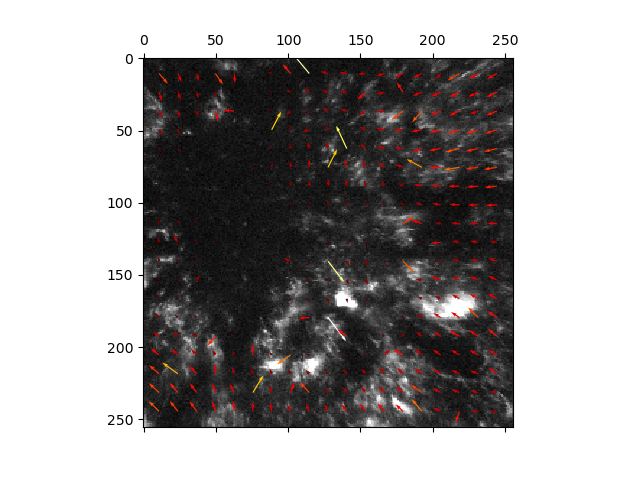

In [21]:
x,y,u3,v3,div = implement_piv(im,55,1,prefilter=False,winsize=11,searchsize=17,overlap=4,noise_threshold=1.6)